Note: This notebook is largely based on this notebook: https://www.kaggle.com/code/abhinand05/vision-transformer-vit-tutorial-baseline, relying on a pretrained model. hyperparameters have been tuned and adjusted for comparison of the various models used in this project. 

Imports and preprocessing

In [ ]:
!pip install cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp39-cp39-linux_x86_64.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 MB 6.8 MB/s eta 0:00:00
  Using cached torch-2.0.0-cp39-cp39-manylinux1_x86_64.whl (619.9 MB)
  Using cached torchvision-0.15.1-cp39-cp39-manylinux1_x86_64.whl (6.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 3.0 MB/s eta 0:00:00
  Using cached nvidia_nccl_cu11-2.14.3-py3-none-manylinux1_x86_64.whl (177.1 MB)
  Using cached nvidia_cuda_cupti_cu11-11.7.101-py3-none-manylinux1_x86_64.whl (11.8 MB)
  Using cached nvidia_cudnn_cu11-8.5.0.96-2-py3-none-manylinux1_x86_64.whl (557.1 MB)
  Using cached nvidia_cufft_cu11-10.9.0.58-py3-none-manylinux1_x86_64.whl (168.4 MB)
  Using cached nvidia_curand_cu11-10.2.10.91-py3-none-manylinux1_x86_64.whl (54.6 MB)
  Using cached nvidia_cuda_nvrtc_cu11-11.7.99-2-py3-none-manylinux1_x86_64.whl (21.0 MB)
  Using cached nvidia_cublas_cu11-11.10.3.66-py3-none-manylinux1_x86_64.whl (317

In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached timm-0.6.13-py3-none-any.whl (549 kB)
  Using cached huggingface_hub-0.14.1-py3-none-any.whl (224 kB)


In [61]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version "nightly"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6028  100  6028    0     0  22000      0 --:--:-- --:--:-- --:--:-- 22000
Updating... This may take around 2 minutes.
Found existing installation: torch 2.0.0
Uninstalling torch-2.0.0:
  Successfully uninstalled torch-2.0.0
Found existing installation: torchvision 0.15.1
Uninstalling torchvision-0.15.1:
  Successfully uninstalled torchvision-0.15.1
Copying gs://tpu-pytorch/wheels/colab/torch-nightly-cp39-cp39-linux_x86_64.whl...
| [1 files][116.3 MiB/116.3 MiB]                                                
Operation completed over 1 objects/116.3 MiB.                                    
Copying gs://tpu-pytorch/wheels/colab/torch_xla-nightly-cp39-cp39-linux_x86_64.whl...
\ [1 files][109.8 MiB/109.8 MiB]                                                
Operation completed over 1 objects/109.8 MiB.                             

In [62]:
import os
FLAGS = {}
FLAGS['batch_size'] = 16
FLAGS['num_workers'] = 8
FLAGS['learning_rate'] = 2e-05
FLAGS['momentum'] = 0.9
FLAGS['num_epochs'] = 200
FLAGS['num_cores'] = 8 #if os.environ.get('TPU_NAME', None) else 1
FLAGS['log_steps'] = 20
FLAGS['metrics_debug'] = False

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ggplot")

In [64]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [65]:
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.distributed.parallel_loader as pl

import timm

import gc
import os
import time
import random
from datetime import datetime

from PIL import Image
from tqdm.notebook import tqdm
from sklearn import model_selection, metrics

In [66]:
os.environ["XLA_USE_BF16"] = "1"
os.environ["XLA_TENSOR_ALLOCATOR_MAXSIZE"] = "100000000"

In [67]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1001)

Create global variables specific to pretrained model

In [68]:

MODEL_PATH = (
    "jx_vit_base_p16_224-80ecf9dd.pth"
)

IMG_SIZE = 224
N_EPOCHS = 3
BATCH_SIZE = 16
LR = 0.02
GAMMA = 0.7


In [19]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [21]:
!unzip gdrive/My\ Drive/cassava-leaf-disease-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_images/3954487465.jpg  
  inflating: train_images/3954910918.jpg  
  inflating: train_images/3955391972.jpg  
  inflating: train_images/3955442838.jpg  
  inflating: train_images/3955739563.jpg  
  inflating: train_images/3955931830.jpg  
  inflating: train_images/3955972139.jpg  
  inflating: train_images/3956075690.jpg  
  inflating: train_images/3956077728.jpg  
  inflating: train_images/3956155774.jpg  
  inflating: train_images/3956271103.jpg  
  inflating: train_images/3956372146.jpg  
  inflating: train_images/3956407201.jpg  
  inflating: train_images/3956550570.jpg  
  inflating: train_images/3956605397.jpg  
  inflating: train_images/3956778160.jpg  
  inflating: train_images/3957562076.jpg  
  inflating: train_images/3957612771.jpg  
  inflating: train_images/3957807023.jpg  
  inflating: train_images/3957819631.jpg  
  inflating: train_images/395820132.jpg  
  inflating: train_images/3958304403.jpg  
  in

In [33]:
!unzip gdrive/My\ Drive/jx_vit_base_p16_224-80ecf9dd.pth.zip

Archive:  gdrive/My Drive/jx_vit_base_p16_224-80ecf9dd.pth.zip
  inflating: jx_vit_base_p16_224-80ecf9dd.pth  


In [69]:
df = pd.read_csv("train.csv")
df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.5+ KB


<Axes: >

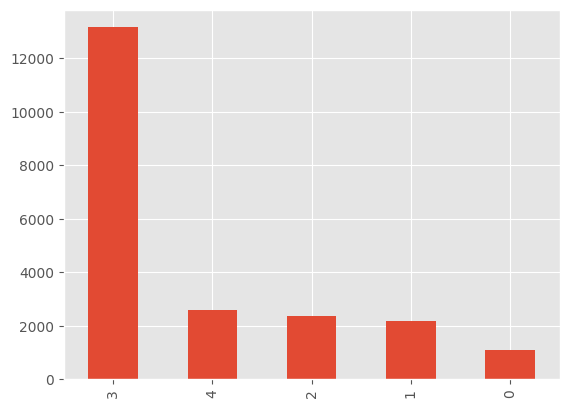

In [71]:
df.label.value_counts().plot(kind="bar")

In [72]:
train_df, valid_df = model_selection.train_test_split(
    df, test_size=0.1, random_state=42, stratify=df.label.values
)

In [73]:
class CassavaDataset(torch.utils.data.Dataset):
    """
    Helper Class to create the pytorch dataset
    """

    def __init__(self, df, data_path=DATA_PATH, mode="train", transforms=None):
        super().__init__()
        self.df_data = df.values
        self.transforms = transforms
        self.mode = mode
        self.data_dir = "train_images" if mode == "train" else "test_images"

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):
        img_name, label = self.df_data[index]
        img_path = os.path.join(self.data_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        if self.transforms is not None:
            image = self.transforms(img)

        return image, label

In [74]:
# create image augmentations
transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

transforms_valid = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

In [75]:
print("Available Vision Transformer Models: ")
timm.list_models("vit*")

Available Vision Transformer Models: 


['vit_base_patch8_224',
 'vit_base_patch8_224_dino',
 'vit_base_patch8_224_in21k',
 'vit_base_patch16_18x2_224',
 'vit_base_patch16_224',
 'vit_base_patch16_224_dino',
 'vit_base_patch16_224_in21k',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_224_miil_in21k',
 'vit_base_patch16_224_sam',
 'vit_base_patch16_384',
 'vit_base_patch16_plus_240',
 'vit_base_patch16_rpn_224',
 'vit_base_patch32_224',
 'vit_base_patch32_224_clip_laion2b',
 'vit_base_patch32_224_in21k',
 'vit_base_patch32_224_sam',
 'vit_base_patch32_384',
 'vit_base_patch32_plus_256',
 'vit_base_r26_s32_224',
 'vit_base_r50_s16_224',
 'vit_base_r50_s16_224_in21k',
 'vit_base_r50_s16_384',
 'vit_base_resnet26d_224',
 'vit_base_resnet50_224_in21k',
 'vit_base_resnet50_384',
 'vit_base_resnet50d_224',
 'vit_giant_patch14_224',
 'vit_giant_patch14_224_clip_laion2b',
 'vit_gigantic_patch14_224',
 'vit_huge_patch14_224',
 'vit_huge_patch14_224_clip_laion2b',
 'vit_huge_patch14_224_in21k',
 'vit_large_patch14_224',
 'vit_large_

In [76]:
class ViTBase16(nn.Module):
    def __init__(self, n_classes, pretrained=False):

        super(ViTBase16, self).__init__()

        self.model = timm.create_model("vit_base_patch16_224", pretrained=False)
        if pretrained:
            self.model.load_state_dict(torch.load(MODEL_PATH))

        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):
        x = self.model(x)
        return x

    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        # keep track of training loss
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        ###################
        # train the model #
        ###################
        self.model.train()
        for i, (data, target) in enumerate(train_loader):
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()
            elif device.type == "xla":
                data = data.to(device, dtype=torch.float32)
                target = target.to(device, dtype=torch.int64)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.forward(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Calculate Accuracy
            accuracy = (output.argmax(dim=1) == target).float().mean()
            # update training loss and accuracy
            epoch_loss += loss
            epoch_accuracy += accuracy

            # perform a single optimization step (parameter update)
            if device.type == "xla":
                xm.optimizer_step(optimizer)

                if i % 20 == 0:
                    xm.master_print(f"\tBATCH {i+1}/{len(train_loader)} - LOSS: {loss}")

            else:
                optimizer.step()

        return epoch_loss / len(train_loader), epoch_accuracy / len(train_loader)

    def validate_one_epoch(self, valid_loader, criterion, device):
        # keep track of validation loss
        valid_loss = 0.0
        valid_accuracy = 0.0

        ######################
        # validate the model #
        ######################
        self.model.eval()
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()
            elif device.type == "xla":
                data = data.to(device, dtype=torch.float32)
                target = target.to(device, dtype=torch.int64)

            with torch.no_grad():
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # Calculate Accuracy
                accuracy = (output.argmax(dim=1) == target).float().mean()
                # update average validation loss and accuracy
                valid_loss += loss
                valid_accuracy += accuracy

        return valid_loss / len(valid_loader), valid_accuracy / len(valid_loader)

In [77]:
def fit_tpu(
    model, epochs, device, criterion, optimizer, train_loader, valid_loader=None
):

    valid_loss_min = np.Inf  # track change in validation loss

    # keeping track of losses as it happen
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(1, epochs + 1):
        gc.collect()
        para_train_loader = pl.ParallelLoader(train_loader, [device])

        xm.master_print(f"{'='*50}")
        xm.master_print(f"EPOCH {epoch} - TRAINING...")
        train_loss, train_acc = model.train_one_epoch(
            para_train_loader.per_device_loader(device), criterion, optimizer, device
        )
        xm.master_print(
            f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss}, ACCURACY: {train_acc}\n"
        )
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        gc.collect()

        if valid_loader is not None:
            gc.collect()
            para_valid_loader = pl.ParallelLoader(valid_loader, [device])
            xm.master_print(f"EPOCH {epoch} - VALIDATING...")
            valid_loss, valid_acc = model.validate_one_epoch(
                para_valid_loader.per_device_loader(device), criterion, device
            )
            xm.master_print(f"\t[VALID] LOSS: {valid_loss}, ACCURACY: {valid_acc}\n")
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)
            gc.collect()

            # save model if validation loss has decreased
            if valid_loss <= valid_loss_min and epoch != 1:
                xm.master_print(
                    "Validation loss decreased ({:.4f} --> {:.4f}).  Saving model ...".format(
                        valid_loss_min, valid_loss
                    )
                )
            #                 xm.save(model.state_dict(), 'best_model.pth')

            valid_loss_min = valid_loss

    return {
        "train_loss": train_losses,
        "valid_losses": valid_losses,
        "train_acc": train_accs,
        "valid_acc": valid_accs,
    }

In [78]:
model = ViTBase16(n_classes=5, pretrained=True)

In [85]:
def _run():
    train_dataset = CassavaDataset(train_df, transforms=transforms_train)
    valid_dataset = CassavaDataset(valid_df, transforms=transforms_valid)

    train_sampler = torch.utils.data.distributed.DistributedSampler(
        train_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True,
    )

    valid_sampler = torch.utils.data.distributed.DistributedSampler(
        valid_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False,
    )

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        sampler=train_sampler,
        drop_last=True,
        num_workers=8,
    )

    valid_loader = torch.utils.data.DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        sampler=valid_sampler,
        drop_last=True,
        num_workers=8,
    )

    criterion = nn.CrossEntropyLoss()
    #     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device = xm.xla_device()
    model.to(device)

    lr = LR * xm.xrt_world_size()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    xm.master_print(f"INITIALIZING TRAINING ON {xm.xrt_world_size()} TPU CORES")
    start_time = datetime.now()
    xm.master_print(f"Start Time: {start_time}")

    logs = fit_tpu(
        model=model,
        epochs=N_EPOCHS,
        device=device,
        criterion=criterion,
        optimizer=optimizer,
        train_loader=train_loader,
        valid_loader=valid_loader,
    )

    xm.master_print(f"Execution time: {datetime.now() - start_time}")

    xm.master_print("Saving Model")
    xm.save(
        model.state_dict(), f'model_5e_{datetime.now().strftime("%Y%m%d-%H%M")}.pth'
    )

In [80]:
print(xm.get_xla_supported_devices())

['xla:0']


In [86]:
# Start training processes
def _mp_fn(rank, flags):
    torch.set_default_tensor_type("torch.FloatTensor")
    a = _run()


# _run()
FLAGS = {}
xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=8, start_method="fork")

INITIALIZING TRAINING ON 1 TPU CORES
Start Time: 2023-04-26 03:54:25.341379
EPOCH 1 - TRAINING...


KeyboardInterrupt: ignored